### APPROACH 1

## SETUP

In [ ]:
!pip install -q "monai[pillow, tqdm, openslide]"
!pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0

In [ ]:
!git clone https://github.com/LG-AI-EXAONE/EXAONEPath.git

fatal: destination path 'EXAONEPath' already exists and is not an empty directory.


In [ ]:
!mkdir macenko_target
!cp '/content/EXAONEPath/macenko_target/target_TCGA-55-A48X_coords_[19440  9824]_[4096 4096].png' '/content/macenko_target'

mkdir: cannot create directory ‘macenko_target’: File exists


In [ ]:
import os
import json
import pandas as pd
import openslide
import torch
import numpy as np
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from huggingface_hub import HfApi, login, hf_hub_download
from monai.data import WSIReader, Dataset
from monai.transforms import (
    LoadImaged,
    Compose,
    RandSpatialCropd,
    EnsureChannelFirstd,
    ScaleIntensityRanged
)
from google.colab import userdata
import torchvision.transforms as transforms
import gc

In [ ]:
try:
    huggingface_token = userdata.get('huggingface')
    login(token=huggingface_token)
except:
    print("Hugging Face token not found in Colab secrets. Proceeding with public access.")

metadata_repo_id = "HistAI/HISTAI-metadata"
wsi_repo_id = "HistAI/HISTAI-colorectal-b2"

In [ ]:
# --- Download and Filter Metadata ---
try:
    metadata_file_path = hf_hub_download(
        repo_id=metadata_repo_id,
        filename="metadata.json",
        repo_type="dataset",
        cache_dir="./metadata_cache"
    )

    with open(metadata_file_path, 'r') as f:
        master_metadata = json.load(f)

    target_dataset_name = "HISTAI-colorectal-b2"

    # Filter metadata based on 'case_mapping' field and use case identifier from case_mapping as the key
    filtered_metadata = {}
    for entry in master_metadata:
        case_mapping = entry.get('case_mapping')
        if case_mapping and target_dataset_name in case_mapping:
            # Extract case identifier from case_mapping (e.g., 'case_58')
            check = entry.get('icd10')
            if 'NONE' in check or ',' in check:
                continue
            case_identifier = case_mapping.split('/')[-1]
            filtered_metadata[case_identifier] = entry

    print(f)
    print(f"Successfully loaded metadata and filtered for '{target_dataset_name}'.")
    print(f"Found {len(filtered_metadata)} cases with metadata.")

    if filtered_metadata:
        sample_case_id = list(filtered_metadata.keys())[0]
        sample_entry = filtered_metadata[sample_case_id]
        print("\nSample metadata entry:")
        for key, value in sample_entry.items():
            print(f"  - {key}: {value}")

except Exception as e:
    print(f"Error downloading or loading metadata: {e}")
    filtered_metadata = {}

<_io.TextIOWrapper name='./metadata_cache/datasets--HistAI--HISTAI-metadata/snapshots/e8f5890441e1690576957cf5f665f4fb57f246a9/metadata.json' mode='r' encoding='utf-8'>
Successfully loaded metadata and filtered for 'HISTAI-colorectal-b2'.
Found 53 cases with metadata.

Sample metadata entry:
  - age: 63
  - gender: f
  - icd10: D01.0
  - specialization: Gastrointestinal
  - case_mapping: histai/HISTAI-colorectal-b2/case_52
  - diagnosis: Sigmoid colon formation.
  - conclusion: Tubulovillous adenoma of the sigmoid colon with high-grade dysplasia, infiltration of the lamina propria (intramucosal carcinoma), and areas suspicious for invasion into the muscularis mucosae.
  - diff_diagnostic: 
  - grossing: Gastrointestinal tract: Colon biopsy. Number of samples: 2. Maximum sample size: 2 mm.
  - micro_protocol: Gastrointestinal tract: Polypoid formations of the colon. Specimen description: Marking: 63463-1-1. Topography: Sigmoid colon. Lesion type: Adenoma. Adenoma variant: Tubulovillous.

In [ ]:
# Get the list of WSI files from the colorectal repository
api = HfApi()
file_list = api.list_repo_files(repo_id=wsi_repo_id, repo_type="dataset")
wsi_files = [f for f in file_list if f.endswith('.tiff')]

# Filter WSI files to include only those with corresponding metadata
wsi_files_with_metadata = []
for f in wsi_files:
    if f.split('/')[0] in filtered_metadata:
        wsi_files_with_metadata.append(f)

print(f"\nFound {len(wsi_files)} WSI files in the {wsi_repo_id} repository.")
print(f"Using {len(wsi_files_with_metadata)} WSI files that have corresponding metadata.")


Found 94 WSI files in the HistAI/HISTAI-colorectal-b2 repository.
Using 72 WSI files that have corresponding metadata.


## DATA GENERATOR

In [ ]:
def get_tissue_mask(slide_path):
    """Memory-safe tissue mask generation"""
    slide = None
    try:
        slide = openslide.OpenSlide(slide_path)
        level = slide.level_count - 1
        dimensions = slide.level_dimensions[level]
        thumbnail = slide.read_region((0, 0), level, dimensions).convert('L')
        thumbnail_np = np.array(thumbnail)
        _, tissue_mask = cv2.threshold(thumbnail_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

        # Clear thumbnail from memory
        del thumbnail, thumbnail_np

        return tissue_mask

    except Exception as e:
        print(f"Error creating tissue mask: {e}")
        return None

    finally:
        # Always close slide, even on error
        if slide is not None:
            slide.close()
        # Force garbage collection
        gc.collect()

In [ ]:
!pip install torchstain

In [ ]:
import os
import torch
import numpy as np
import openslide
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download
import sys

# Add EXAONEPath to path
sys.path.append('/content/EXAONEPath')
from macenko import macenko_normalizer

class WSI_MONAI_Dataset(Dataset):
    def __init__(self, repo_id, file_list, metadata, num_patches=32, patch_size=224, patch_level=0):
        """
        WSI dataset with proper dictionary metadata handling

        Args:
            repo_id: HuggingFace repository ID
            file_list: List of WSI file paths
            metadata: Dict with structure {case_id: {age, gender, icd10, ...}}
            num_patches: Number of patches per WSI
            patch_size: Size of patches (224 for EXAONEPath)
            patch_level: OpenSlide level for extraction
        """
        self.repo_id = repo_id
        self.file_list = file_list
        self.metadata = metadata
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.patch_level = patch_level

        print("Creating consistent label mappings...")

        # Create label mappings
        self._create_label_mappings()

        # Initialize Macenko normalizer
        self.macenko_normalizer = macenko_normalizer()

        # ImageNet normalization
        self.imagenet_normalize = transforms.Normalize(
            mean=(0.485, 0.456, 0.406),
            std=(0.229, 0.224, 0.225)
        )

    def _create_label_mappings(self):
        """Create label mappings from dictionary metadata"""

        valid_files = []
        valid_labels = []
        missing_cases = []

        print("Matching files with metadata...")

        for file_path in self.file_list:
            case_id = file_path.split('/')[0]

            # Check if case exists in metadata
            if case_id in self.metadata:
                case_info = self.metadata[case_id]

                # Get ICD-10 label
                if 'icd10' in case_info and case_info['icd10'] is not None:
                    icd10_code = str(case_info['icd10']).strip()

                    if icd10_code and icd10_code != 'nan' and icd10_code != '':
                        valid_files.append(file_path)
                        valid_labels.append(icd10_code)

                    else:
                        print(f"   ⚠️ {case_id}: Empty ICD-10 code")
                else:
                    print(f"   ⚠️ {case_id}: No 'icd10' key in metadata")
            else:
                missing_cases.append(case_id)

        # Report missing cases
        if missing_cases:
            print(f"   ❌ Cases not found in metadata: {missing_cases[:10]}...")  # Show first 10

        if len(valid_files) == 0:
            raise ValueError("❌ No files found with valid ICD-10 labels!")

        # Create final mappings
        self.file_list = valid_files
        self.icd10_labels = sorted(list(set(valid_labels)))
        self.label_to_idx = {label: idx for idx, label in enumerate(self.icd10_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        # Show label distribution
        from collections import Counter
        label_counts = Counter(valid_labels)

    def get_icd10_from_idx(self, idx):
        """Convert label index back to ICD-10 code"""
        return self.idx_to_label.get(idx, "Unknown")

    def get_case_info(self, case_id):
        """Get all info for a case"""
        return self.metadata.get(case_id, {})

    def _generate_tissue_mask(self, slide):
        """Generate tissue mask using Otsu thresholding"""
        level = slide.level_count - 1
        dimensions = slide.level_dimensions[level]
        thumbnail = slide.read_region((0, 0), level, dimensions).convert('L')
        thumbnail_np = np.array(thumbnail)
        _, tissue_mask = cv2.threshold(thumbnail_np, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        return tissue_mask, slide.level_downsamples[level]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path = self.file_list[idx]
        case_id = file_path.split('/')[0]

        # Get ICD-10 label for this case
        if case_id in self.metadata:
            icd10_code = str(self.metadata[case_id]['icd10'])
            label = self.label_to_idx.get(icd10_code, -1)
        else:
            print(f"⚠️ No metadata found for case: {case_id}")
            return None, None

        if label == -1:
            print(f"⚠️ Unknown ICD-10 code '{icd10_code}' for case: {case_id}")
            return None, None

        # Download and process slide
        try:
            print(f"Downloading file: {file_path} (ICD-10: {icd10_code}) ......")
            local_path = hf_hub_download(
                repo_id=self.repo_id,
                filename=file_path,
                repo_type="dataset",
                cache_dir="./wsi_cache"
            )

            slide = openslide.OpenSlide(local_path)

            # Generate tissue mask
            tissue_mask, downsample_factor = self._generate_tissue_mask(slide)
            tissue_coords = np.argwhere(tissue_mask > 0)

            if len(tissue_coords) == 0:
                print(f"⚠️ No tissue found in {file_path}")
                slide.close()
                if os.path.exists(local_path):
                    os.remove(local_path)
                return None, None

            # Extract patches from tissue regions
            patches_list = []
            max_attempts = self.num_patches * 3
            attempts = 0

            while len(patches_list) < self.num_patches and attempts < max_attempts:
                attempts += 1

                # Random tissue location
                y_m, x_m = tissue_coords[np.random.randint(len(tissue_coords))]
                x_level0 = int(x_m * downsample_factor)
                y_level0 = int(y_m * downsample_factor)

                try:
                    # Extract patch
                    patch = slide.read_region(
                        (x_level0, y_level0),
                        self.patch_level,
                        (self.patch_size, self.patch_size)
                    ).convert('RGB')

                    # Apply Macenko normalization
                    patch_macenko = self.macenko_normalizer(patch)

                    # Apply ImageNet normalization
                    patch_final = self.imagenet_normalize(patch_macenko)

                    patches_list.append(patch_final)

                except Exception as e:
                    continue

            slide.close()

            # Clean up downloaded file
            if os.path.exists(local_path):
                os.remove(local_path)

            if len(patches_list) == 0:
                print(f"❌ No valid patches extracted from {file_path}")
                return None, None

            # Pad with zeros if we don't have enough patches
            while len(patches_list) < self.num_patches:
                patches_list.append(torch.zeros_like(patches_list[0]))

            # Stack patches into tensor
            patches_tensor = torch.stack(patches_list)  # Shape: [num_patches, 3, 224, 224]

            return patches_tensor, torch.tensor(label, dtype=torch.long)

        except Exception as e:
            print(f"❌ Error processing {file_path}: {e}")
            return None, None


# Keep the same custom collate function and denormalization function
def custom_collate_fn(batch):
    """Custom collate function to handle None values"""
    batch = [item for item in batch if item[0] is not None and item[1] is not None]

    if len(batch) == 0:
        return None, None

    patches = torch.stack([item[0] for item in batch])
    labels = torch.stack([item[1] for item in batch])

    return patches, labels


def denormalize_imagenet(tensor):
    """Denormalize ImageNet-normalized tensor for display"""
    denorm = tensor.clone()
    denorm[0] = denorm[0] * 0.229 + 0.485
    denorm[1] = denorm[1] * 0.224 + 0.456
    denorm[2] = denorm[2] * 0.225 + 0.406
    return torch.clamp(denorm, 0, 1)

Creating consistent label mappings...
Matching files with metadata...


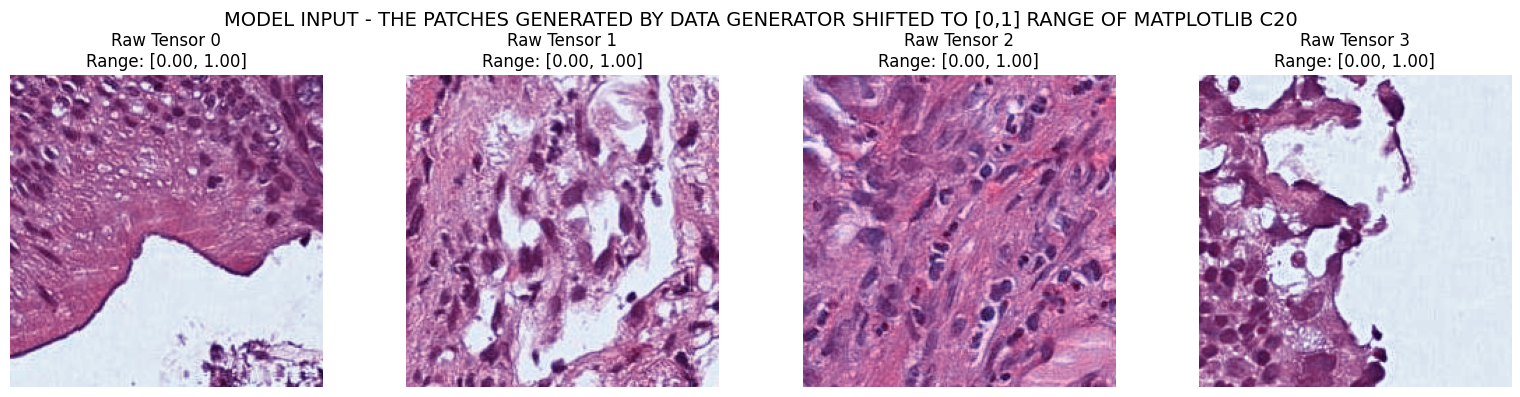

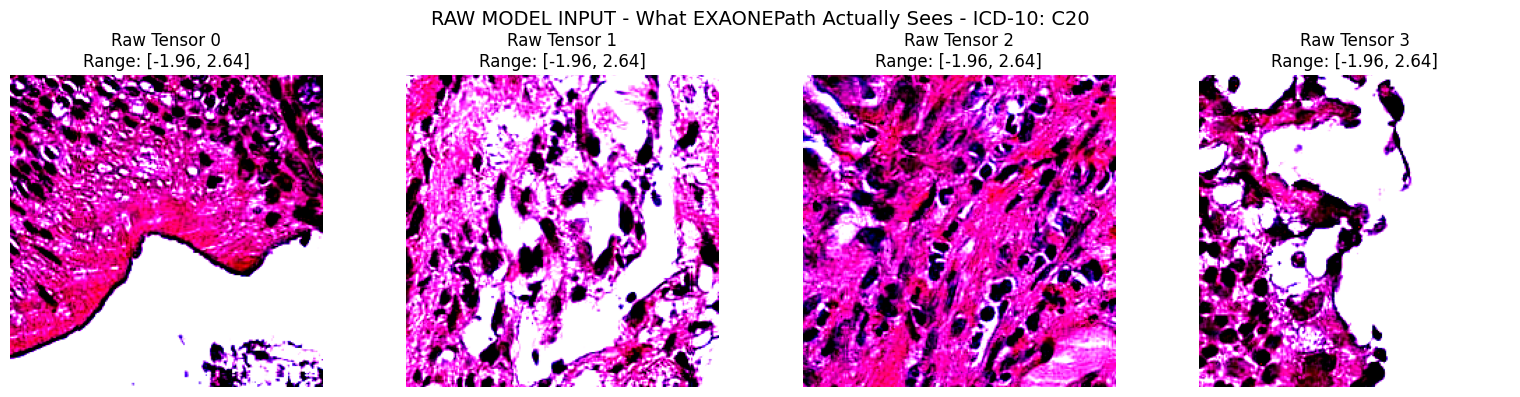

In [ ]:
# TESTING DATA GENERATOR
dataset = WSI_MONAI_Dataset(
    repo_id=wsi_repo_id,
    file_list=wsi_files_with_metadata[:3],
    metadata=filtered_metadata,
    num_patches=4,
    patch_size=224,
    patch_level=0
)

patches, label = dataset[0]
icd10_label = dataset.get_icd10_from_idx(label.item())

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(f'MODEL INPUT - THE PATCHES GENERATED BY DATA GENERATOR SHIFTED TO [0,1] RANGE OF MATPLOTLIB {icd10_label}', fontsize=14)

for i in range(4):
    raw_tensor = patches[i]
    display_tensor = (raw_tensor - raw_tensor.min()) / (raw_tensor.max() - raw_tensor.min())

    axes[i].imshow(display_tensor.permute(1, 2, 0).numpy())
    axes[i].set_title(f'Raw Tensor {i}\nRange: [{display_tensor.min():.2f}, {display_tensor.max():.2f}]')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
fig.suptitle(f'RAW MODEL INPUT - What EXAONEPath Actually Sees - ICD-10: {icd10_label}', fontsize=14)

for i in range(4):
    axes[i].imshow(patches[i].permute(1, 2, 0).numpy())
    axes[i].set_title(f'Raw Tensor {i}\nRange: [{raw_tensor.min():.2f}, {raw_tensor.max():.2f}]')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Model

In [ ]:
from monai.data import WSIReader
import torch.nn as nn
from monai.networks.blocks import TransformerBlock
from google.colab import userdata
import torchvision.transforms as transforms
import requests
from io import BytesIO

# --- Define the Vision Transformer Model Pipeline ---
class WSI_EXAONEPath_Classifier(nn.Module):
    def __init__(self, num_classes=13):
        super().__init__()

        print("Initializing WSI EXAONEPath Classifier...")

        # Load frozen EXAONEPath
        self.backbone = self._load_frozen_exaonepath()

        # Aggregation layers (trainable)
        self.aggregator = nn.Sequential(
            nn.Linear(768, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Classification head (trainable)
        self.classifier = nn.Linear(256, num_classes)

        # Print parameter counts
        self._print_parameter_info()

    def _load_frozen_exaonepath(self):
        """Load EXAONEPath from HuggingFace using official method with correct paths"""
        try:
            # Add the cloned repo to Python path
            import sys
            sys.path.append('/content/EXAONEPath')

            # Import from the cloned repository
            from vision_transformer import VisionTransformer

            from google.colab import userdata
            hf_token = userdata.get('huggingface')

            # Login to HuggingFace
            from huggingface_hub import login
            login(token=hf_token)

            # Load using the huggingface
            model = VisionTransformer.from_pretrained(
                "LGAI-EXAONE/EXAONEPath",
                use_auth_token=hf_token
            )

            print("✅ Successfully loaded EXAONEPath from HuggingFace")

        except Exception as e:
            print(f"⚠️ HuggingFace loading failed: {e}")
            print("📥 Falling back to manual checkpoint loading...")

            # Fallback: Load manually
            try:
                # Import from cloned repo
                import sys
                sys.path.append('/content/EXAONEPath')
                from vision_transformer import vit_base

                # Download checkpoint if not exists
                checkpoint_url = "https://github.com/LG-AI-EXAONE/EXAONEPath/releases/download/1.0.0/EXAONEPath.ckpt"
                checkpoint_path = "/content/EXAONEPath.ckpt"

                if not os.path.exists(checkpoint_path):
                    print("Downloading EXAONEPath checkpoint...")
                    import urllib.request
                    urllib.request.urlretrieve(checkpoint_url, checkpoint_path)
                    print(f"Downloaded checkpoint to {checkpoint_path}")

                #Load manually
                checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
                state_dict = checkpoint['state_dict']
                model = vit_base(patch_size=16, num_classes=0)  # num_classes=0 for feature extraction
                msg = model.load_state_dict(state_dict, strict=False)
                print(f'Pretrained weights loaded with msg: {msg}')

            except Exception as e2:
                print(f"❌ Manual loading also failed: {e2}")
                # Last resort: random weights with warning
                import sys
                sys.path.append('/content/EXAONEPath')
                from vision_transformer import vit_base
                model = vit_base(patch_size=16, num_classes=0)
                print(" [WARNING] : Using random weights - performance will be poor!")

        # Freeze all parameters
        for param in model.parameters():
            param.requires_grad = False

        model.eval()
        return model

    def _print_parameter_info(self):
        """Print information about trainable vs frozen parameters"""
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        frozen_params = sum(p.numel() for p in self.parameters() if not p.requires_grad)

        print(f"Model initialized:")
        print(f"   - EXAONEPath: FROZEN ({frozen_params:,} params)")
        print(f"   - Aggregator + Classifier: TRAINABLE ({trainable_params:,} params)")
        print(f"Trainable parameters: {trainable_params:,}")
        print(f"Frozen parameters: {frozen_params:,}")

    def forward(self, patches):
        # patches shape: [batch_size, num_patches, channels, height, width]
        batch_size, num_patches = patches.shape[:2]

        # Reshape for backbone processing
        patches_flat = patches.view(-1, *patches.shape[2:])  # [batch_size*num_patches, C, H, W]

        # Extract features using frozen EXAONEPath
        with torch.no_grad():
            features = self.backbone(patches_flat)  # [batch_size*num_patches, 768]

        # Reshape back to [batch_size, num_patches, 768]
        features = features.view(batch_size, num_patches, -1)

        # Aggregate features (mean pooling)
        aggregated_features = torch.mean(features, dim=1)  # [batch_size, 768]

        # Pass through trainable layers
        aggregated_features = self.aggregator(aggregated_features)  # [batch_size, 256]
        logits = self.classifier(aggregated_features)  # [batch_size, num_classes]

        return logits

    def get_feature_maps(self, patches):
        """For analysis - get intermediate features"""
        patch_features = self.extract_patch_features(patches)
        aggregated_features = torch.mean(patch_features, dim=1)
        processed_features = self.aggregator(aggregated_features)

        return {
            'patch_features': patch_features,
            'aggregated_features': aggregated_features,
            'processed_features': processed_features
        }

In [ ]:
# Fix the model creation function
def create_wsi_model(num_classes):
    """Create the WSI classification model"""
    model = WSI_EXAONEPath_Classifier(num_classes=num_classes)
    return model

# Optimizer setup (only train aggregator + classifier)
def setup_optimizer(model, learning_rate=1e-4):
    """Setup optimizer for trainable parameters only"""

    # Get only trainable parameters (aggregator + classifier)
    trainable_params = [p for p in model.parameters() if p.requires_grad]

    print(f"📊 Trainable parameters: {sum(p.numel() for p in trainable_params):,}")
    print(f"📊 Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")

    # Lower learning rate for stability
    optimizer = torch.optim.AdamW(
        trainable_params,
        lr=learning_rate,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )

    # Simple scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=50,  # 50 epochs
        eta_min=1e-6
    )

    return optimizer, scheduler

In [ ]:
def custom_collate_fn(batch):
    # Filter out None values
    batch = [item for item in batch if item[0] is not None and item[1] is not None]

    if len(batch) == 0:
        return None, None

    # Use the default collate function for valid items
    return torch.utils.data.dataloader.default_collate(batch)

##TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

IGNORE NEXT BLOCK

In [ ]:
# from sklearn.model_selection import train_test_split
# from collections import Counter

# # Create label list for stratification
# file_labels = []
# for file_path in wsi_files_with_metadata:
#     case_id = file_path.split('/')[0]
#     icd10_code = filtered_metadata.get(case_id, {}).get('icd10', 'Unknown')
#     file_labels.append(icd10_code)

# print("Label distribution in full dataset:")
# label_counts = Counter(file_labels)
# for label, count in sorted(label_counts.items()):
#     print(f"  {label}: {count} files")

# # Stratified split to maintain class balance
# try:
#     train_files, val_files, train_labels, val_labels = train_test_split(
#         wsi_files_with_metadata,
#         file_labels,
#         test_size=0.2,
#         random_state=42,
#         stratify=file_labels  # This ensures balanced classes
#     )

#     print("\nAfter stratified split:")
#     print(f"Train: {len(train_files)} files")
#     print(f"Validation: {len(val_files)} files")

#     print("\nTrain label distribution:")
#     train_counts = Counter(train_labels)
#     for label, count in sorted(train_counts.items()):
#         print(f"  {label}: {count} files")

#     print("\nValidation label distribution:")
#     val_counts = Counter(val_labels)
#     for label, count in sorted(val_counts.items()):
#         print(f"  {label}: {count} files")

# except ValueError as e:
#     print(f"Stratification failed (probably due to insufficient samples per class): {e}")
#     print("Falling back to random split...")

#     # Fallback to random split
#     train_files, val_files = train_test_split(
#         wsi_files_with_metadata,
#         test_size=0.2,
#         random_state=42
#     )

In [ ]:
def create_train_val_datasets(repo_id,wsi_files_with_metadata,filtered_metadata,test_size=0.2,random_state=42,num_patches=32,patch_size=224,patch_level=0,verbose=False):
    from sklearn.model_selection import train_test_split
    from collections import Counter

    # Create label list for stratification
    file_labels = []
    for file_path in wsi_files_with_metadata:
        case_id = file_path.split('/')[0]
        icd10_code = filtered_metadata.get(case_id, {}).get('icd10', 'Unknown')
        file_labels.append(icd10_code)

    if verbose:
        print("Label distribution in full dataset:")
        label_counts = Counter(file_labels)
        for label, count in sorted(label_counts.items()):
            print(f"   {label}: {count} files")

    # Attempt stratified split to maintain class balance
    try:
        train_files, val_files, train_labels, val_labels = train_test_split(
            wsi_files_with_metadata,
            file_labels,
            test_size=test_size,
            random_state=random_state,
            stratify=file_labels
        )

        if verbose:
            print(f"\n Stratified split successful:")
            print(f"   Train: {len(train_files)} files")
            print(f"   Validation: {len(val_files)} files")

            print(f"\n Train label distribution:")
            train_counts = Counter(train_labels)
            for label, count in sorted(train_counts.items()):
                print(f"   {label}: {count} files")

            print(f"\n Validation label distribution:")
            val_counts = Counter(val_labels)
            for label, count in sorted(val_counts.items()):
                print(f"   {label}: {count} files")

    except ValueError as e:
        if verbose:
            print(f"Stratification failed: {e}")
            print("Falling back to random split...")

        train_files, val_files = train_test_split(
            wsi_files_with_metadata,
            test_size=test_size,
            random_state=random_state
        )

        if verbose:
            print(f"Random split completed:")
            print(f"   Train: {len(train_files)} files")
            print(f"   Validation: {len(val_files)} files")

    # Create datasets
    if verbose:
        print(f"\n Creating train dataset...")

    train_dataset = WSI_MONAI_Dataset(
        repo_id=repo_id,
        file_list=train_files,
        metadata=filtered_metadata,
        num_patches=num_patches,
        patch_size=patch_size,
        patch_level=patch_level
    )

    if verbose:
        print(f"\n Creating validation dataset...")

    val_dataset = WSI_MONAI_Dataset(
        repo_id=repo_id,
        file_list=val_files,
        metadata=filtered_metadata,
        num_patches=num_patches,
        patch_size=patch_size,
        patch_level=patch_level
    )

    if verbose:
        print(f"\n Datasets created successfully!")
        print(f"   Train dataset: {len(train_dataset)} samples")
        print(f"   Val dataset: {len(val_dataset)} samples")
        print(f"   Classes: {train_dataset.icd10_labels}")

    return train_dataset, val_dataset


# Usage example:
if __name__ == '__main__':
    # Create train and validation datasets
    train_dataset, val_dataset = create_train_val_datasets(
        repo_id=wsi_repo_id,
        wsi_files_with_metadata=wsi_files_with_metadata,
        filtered_metadata=filtered_metadata,
        test_size=0.2,
        random_state=42,
        num_patches=32,
        patch_size=224,
        patch_level=0,
        verbose=True
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        collate_fn=custom_collate_fn,
        num_workers=2
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=4,
        shuffle=False,
        collate_fn=custom_collate_fn,
        num_workers=2
    )

    print(f"\n🚀 Ready for training!")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")

Label distribution in full dataset:
   C18: 29 files
   C18.7: 5 files
   C20: 8 files
   D00.2: 1 files
   D01.0: 5 files
   D01.1: 1 files
   D01.2: 3 files
   D12: 7 files
   D12.2: 4 files
   D12.4: 1 files
   D12.5: 3 files
   D12.8: 4 files
   D18: 1 files
Stratification failed: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Falling back to random split...
Random split completed:
   Train: 57 files
   Validation: 15 files

 Creating train dataset...
Creating consistent label mappings...
Matching files with metadata...

 Creating validation dataset...
Creating consistent label mappings...
Matching files with metadata...

 Datasets created successfully!
   Train dataset: 57 samples
   Val dataset: 15 samples
   Classes: ['C18', 'C18.7', 'C20', 'D00.2', 'D01.0', 'D01.1', 'D01.2', 'D12', 'D12.2', 'D12.4', 'D12.5', 'D12.8', 'D18']

🚀 Ready for training!
   Train batches: 15
   Val batches: 4


In [ ]:
# Create the datasets
train_dataset, val_dataset = create_train_val_datasets(wsi_repo_id,wsi_files_with_metadata,filtered_metadata,0.2,82,32,224,0,True)
num_classes = len(train_dataset.icd10_labels)

Label distribution in full dataset:
   C18: 29 files
   C18.7: 5 files
   C20: 8 files
   D00.2: 1 files
   D01.0: 5 files
   D01.1: 1 files
   D01.2: 3 files
   D12: 7 files
   D12.2: 4 files
   D12.4: 1 files
   D12.5: 3 files
   D12.8: 4 files
   D18: 1 files
Stratification failed: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
Falling back to random split...
Random split completed:
   Train: 57 files
   Validation: 15 files

 Creating train dataset...
Creating consistent label mappings...
Matching files with metadata...

 Creating validation dataset...
Creating consistent label mappings...
Matching files with metadata...

 Datasets created successfully!
   Train dataset: 57 samples
   Val dataset: 15 samples
   Classes: ['C18', 'C18.7', 'C20', 'D00.2', 'D01.0', 'D01.1', 'D01.2', 'D12', 'D12.2', 'D12.4', 'D12.5', 'D12.8', 'D18']


In [ ]:
def setup_data_loaders(train_dataset, val_dataset, batch_size=16, num_workers=2):
    """
    Setup data loaders for training and validation
    """
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_loader, val_loader

def train_one_epoch(model, train_loader, criterion, optimizer, device, grad_clip=1.0):
    """
    Train the model for one epoch
    """
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    for patches, labels in tqdm(train_loader, desc="Training", leave=False):
        patches, labels = patches.to(device), labels.to(device)

        # Forward pass
        logits = model(patches)
        loss = criterion(logits, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        # Accumulate loss and predictions
        running_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    """
    Validate the model
    """
    model.eval()
    running_loss = 0.0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for patches, labels in tqdm(val_loader, desc="Validation", leave=False):
            patches, labels = patches.to(device), labels.to(device)

            # Forward pass
            logits = model(patches)
            loss = criterion(logits, labels)

            # Accumulate loss and predictions
            running_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc


def train_model(model, train_loader, val_loader, num_classes, device, num_epochs=25, learning_rate=1e-4):
    """
    Train the EXAONEPath classifier
    """
    # Loss function for classification
    criterion = nn.CrossEntropyLoss()

    # Optimizer only for trainable parts
    optimizer, scheduler = setup_optimizer(model, learning_rate=learning_rate)

    best_val_acc = 0.0
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Train for one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

        # Validate after each epoch
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Logging
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{num_classes}_classes.pth")
            print(f"✅ Best model saved with val_acc: {val_acc:.4f}")

    print(f"Training complete. Best validation accuracy: {best_val_acc:.4f}")

def run_training_pipeline(train_dataset, val_dataset, num_classes, num_epochs=5, batch_size=16):
    """
    End-to-end training pipeline
    """
    # Setup device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Setup data loaders
    train_loader, val_loader = setup_data_loaders(train_dataset, val_dataset, batch_size=batch_size)

    # Initialize model
    model = create_wsi_model(num_classes=num_classes)
    model = model.to(device)

    # Train the model
    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_classes=num_classes,
        device=device,
        num_epochs=num_epochs,
        learning_rate=1e-4
    )

In [ ]:
run_training_pipeline(train_dataset,val_dataset,num_classes,3)

Initializing WSI EXAONEPath Classifier...
✅ Successfully loaded EXAONEPath from HuggingFace
Model initialized:
   - EXAONEPath: FROZEN (85,798,656 params)
   - Aggregator + Classifier: TRAINABLE (528,397 params)
Trainable parameters: 528,397
Frozen parameters: 85,798,656
📊 Trainable parameters: 528,397
📊 Frozen parameters: 85,798,656
Epoch 1/3


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:  25%|██▌       | 1/4 [02:08<06:24, 128.18s/it]

Training:  50%|█████     | 2/4 [02:13<01:51, 55.81s/it] 

Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 2.5034, Train Acc: 0.1228
Val Loss: 2.3125, Val Acc: 0.3333
✅ Best model saved with val_acc: 0.3333
Epoch 2/3


Training:   0%|          | 0/4 [00:00<?, ?it/s]

Training:  25%|██▌       | 1/4 [02:03<06:09, 123.33s/it]

Training:  50%|█████     | 2/4 [02:08<01:47, 53.83s/it] 

linalg.eigh: The algorithm failed to converge because the input matrix is ill-conditioned or has too many repeated eigenvalues (error code: 2).
kthvalue(): Expected reduction dim 0 to have non-zero size.


Validation:   0%|          | 0/1 [00:00<?, ?it/s]

Train Loss: 2.1720, Train Acc: 0.4386
Val Loss: 2.1658, Val Acc: 0.3333
Epoch 3/3


Training:   0%|          | 0/4 [00:00<?, ?it/s]


❌ Error processing case_30/slide_H&E_0.tiff: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
❌ Error processing case_48/slide_H&E_0.tiff: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
❌ Error processing case_33/slide_H&E_0.tiff: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet connection is on.
❌ Error processing case_18/slide_H&E_0.tiff: An error happened while trying to locate the file on the Hub and we cannot find the requested files in the local cache. Please check your connection and try again or make sure your Internet conne

AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 269, in collate_tensor_fn
    numel = sum(x.numel() for x in batch)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/_utils/collate.py", line 269, in <genexpr>
    numel = sum(x.numel() for x in batch)
                ^^^^^^^
AttributeError: 'NoneType' object has no attribute 'numel'
